# Otimização de Estoque no Varejo Online (Data Science & PCP)
**Autor:** Davi Duarte Cucco

**Dataset:** Online Retail II (UCI Repository)

## O Problema de Negócio
No varejo, o estoque é um "cobertor curto":
* **Estoque demais:** Dinheiro parado e custo de armazenagem (Holding Cost).
* **Estoque de menos:** Ruptura (Stockout) e perda de vendas.

Neste projeto, analisamos um *Best Seller* de um e-commerce real do Reino Unido que apresenta **Demanda Errática** (alta volatilidade). O objetivo é calcular matematicamente a política ótima de compras para garantir **95% de Nível de Serviço**.

In [115]:
#Importanto libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm  #Trabalhar com z-score (Curva Normal)

In [116]:
#URL do Dataset (Online Retail II do repositório UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df_raw = pd.read_excel(url)

In [117]:
print(f"Linhas originais: {df_raw.shape[0]}")

Linhas originais: 525461


In [118]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [119]:
df_raw.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [120]:
#Limpeza dos Dados (Data Cleaning)
# Remover canselamentos (Invoice começa com 'C') e quantidades negativas
df_clean = df_raw[~df_raw["Invoice"].astype(str).str.startswith("C")] #Cancelamentos
df_clean = df_clean[df_clean["Quantity"] > 0] #QTD negativo

#Remover possíveis preços zerados ou negativos (Erros de sistema)
df_clean = df_clean[df_clean["Price"] > 0]

#Focar apenas no Reino Unido (Simplificação Geográfica)
df_uk = df_clean[df_clean["Country"] == "United Kingdom"].copy()

#Ajustar data
df_uk["InvoiceDate"] = pd.to_datetime(df_uk["InvoiceDate"]).dt.date

#Mostrar quantas linhas restaram após a limpeza
print(f"Linhas após limpeza: {df_uk.shape[0]}")

Linhas após limpeza: 473378


In [121]:
display(df_uk.head())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom


In [122]:
#Achando o produto que mais vende para aplicar a inteligência nele
#Através do método da Curva ABC

#Agrupar por Produto
top_products = df_uk.groupby(["StockCode", "Description"]).agg({
    "Quantity": "sum", #Valor
    "Price": "mean" #Preço Médio
}).sort_values("Quantity", ascending = False).reset_index() #Ordenar de forma Descescente por Qtd e reiniciar os idx

#Mostrar os 5 mais vendidos
print(" --- Top 5 Produtos Mais Vendidos --- ")
display(top_products.head()) #Mostra as 5 primeiras linhas

 --- Top 5 Produtos Mais Vendidos --- 


,StockCode,Description,Quantity,Price
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,52962,3.054235
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,51827,0.244384
2,17003,BROCADE RING PURSE,48186,0.241316
3,84879,ASSORTED COLOUR BIRD ORNAMENT,42278,2.011377
4,21212,PACK OF 72 RETRO SPOT CAKE CASES,36754,0.681703


In [123]:
#Captando o campeão
cod_campeao = top_products.iloc[0]['StockCode']
nome_campeao = top_products.iloc[0]['Description']
print(f"\n Produto para otimizar o estoque: {cod_campeao} - {nome_campeao}")


 Produto para otimizar o estoque: 85123A - WHITE HANGING HEART T-LIGHT HOLDER


In [124]:
#Para realizar a otimização estocástica, precisamos transformar os dados transacionais em uma Série Temporal diária
#O programa precisa saber qual a média de vendas diária e quanto essa venda varia
#O Histórico diário deste produto será a Série Temporal que será analisada

df_produto = df_uk[df_uk["StockCode"] == cod_campeao].copy()

In [125]:
print(f"Numero de linhas: {df_produto.shape[0]}")

Numero de linhas: 3308


In [126]:
#Agrupar por dia (Soma das vendas por dia)
#Esse DataBase é de notas fiscais. Delas, será extraída a demanda diária
df_diario = df_produto.groupby("InvoiceDate")["Quantity"].sum().reset_index()

In [127]:
display(df_diario.head())

,InvoiceDate,Quantity
0,2009-12-01,255
1,2009-12-02,270
2,2009-12-03,359
3,2009-12-04,167
4,2009-12-05,96


In [128]:
# Certificar se que df_diario foi corretamente definido como um DataFrame a partir de df_produto
# Esta linha foi adicionada preventivamente para evitar problemas caso df_diario não tenha sido inicializado corretamente a montante
df_diario = df_produto.groupby("InvoiceDate")["Quantity"].sum().reset_index()

df_diario = df_diario.rename(columns={"Quantity": "Demanda", "InvoiceDate": "Data"}) #Renomear colunas
df_diario["Data"] = pd.to_datetime(df_diario["Data"]) #Fortatando em data (garantia)

#Garantir que todos os dias apareçam (mesmo os dias de venda zero)
#Criar índice com todas as datas do período
todos_dias = pd.date_range(start=df_diario["Data"].min(), end=df_diario["Data"].max(), freq='D')
df_diario = df_diario.set_index("Data").reindex(todos_dias, fill_value=0).reset_index()
df_diario = df_diario.rename(columns={"index": "Data"})

In [129]:
media_diaria = df_diario["Demanda"].mean() #Media
desvio_padrao = df_diario["Demanda"].std() #Desvio Padrão

print(f" --- Estatística do produto: {nome_campeao} --- ")
print(f"Média de Vendas (μ):{media_diaria:.2f} unidades/dia")
print(f"Desvio Padrão (σ):{desvio_padrao:.2f} unidades/dia")
print(f"Coeficiente de Variação (CV): {(desvio_padrao/media_diaria):.2f}") #Quanto maior, mais difíciç prever

 --- Estatística do produto: WHITE HANGING HEART T-LIGHT HOLDER --- 
Média de Vendas (μ):141.61 unidades/dia
Desvio Padrão (σ):160.56 unidades/dia
Coeficiente de Variação (CV): 1.13


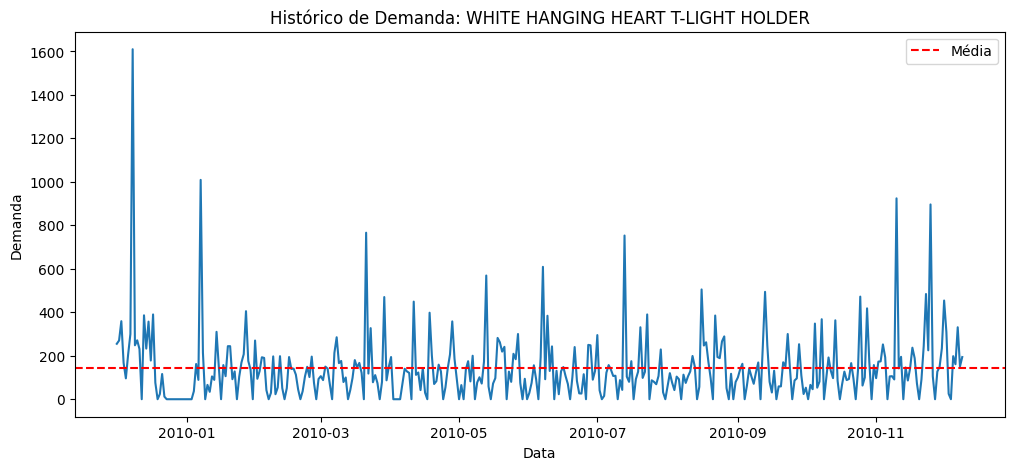

In [130]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_diario, x="Data", y="Demanda")
plt.axhline(media_diaria, color='red', linestyle= '--', label='Média')
plt.title(f"Histórico de Demanda: {nome_campeao}")
plt.legend()
plt.show()

## Metodologia: Otimização Probabilística
Como o produto apresenta um Coeficiente de Variação (CV) > 1.0 (Desvio Padrão maior que a Média), utilizar médias simples levaria a rupturas constantes.

Foram implementadas duas abordagens clássicas de Engenharia de Produção:
1.  **EOQ (Economic Order Quantity):** Para definir o lote de compra que minimiza a soma de custos fixos de frete vs. custos variáveis de armazenagem.
2.  **Ponto de Ressuprimento com Estoque de Segurança:** Calculado com base na distribuição normal da demanda e no Lead Time, para cobrir a incerteza.

In [131]:
import numpy as np
from scipy.stats import norm

#Definindo as Funções

def calcular_eoq(demanda_anual, custo_pedido, custo_manutencao_anual):

    #Calcula o Lote Econômico de Compra (EOQ)
    #Fórmula de Wilson: Raiz(2 * D * K / h)

    return np.sqrt((2 * demanda_anual * custo_pedido) / custo_manutencao_anual)

def calcular_ponto_ressuprimento(media_diaria, desvio_diario, lead_time, nivel_servico):
    #Calcula o Ponto de Pedido considerando Estoque de Segurança.

    #Demanda durante o Lead Time
    demanda_lead_time = media_diaria * lead_time

    #Incerteza (Desvio) durante o Lead Time
    #A variância soma, o desvio é a raiz da soma da variância -> desvio * raiz(tempo)
    desvio_lead_time = desvio_diario * np.sqrt(lead_time)

    #Fator Z (Quantos desvios preciso cobrir para atingir X% de serviço?)
    # Ex: 95% -> Z = 1.645
    z_score = norm.ppf(nivel_servico)

    #Estoque de Segurança
    estoque_seguranca = z_score * desvio_lead_time

    #Ponto de Ressuprimento
    rop = demanda_lead_time + estoque_seguranca

    return rop, estoque_seguranca

#Inputs do Negócio

# Estatísticas do Produto (Vêm da análise anterior)
media_demanda = 141.61   #Média
desvio_padrao = 160.56   #Desvio

# Custos e Logística
lead_time = 7            #Dias
custo_pedido = 50.00     #£50 por pedido
custo_manutencao = 0.05  #£0.05 por unidade/dia
nivel_servico = 0.95     #Quero 95% de garantia

#Executando os Cálculos

#Ajuste para base anual (para o EOQ)
demanda_anual = media_demanda * 365
custo_manutencao_anual = custo_manutencao * 365

#Calculando
eoq = calcular_eoq(demanda_anual, custo_pedido, custo_manutencao_anual)
rop, safety_stock = calcular_ponto_ressuprimento(media_demanda, desvio_padrao, lead_time, nivel_servico)

#Relatório Final

print("="*50)
print(f"RELATÓRIO DE OTIMIZAÇÃO DE ESTOQUE")
print("="*50)
print(f"Produto: Demanda Média={media_demanda:.1f} | Desvio={desvio_padrao:.1f}")
print(f"Política: Nível de Serviço Desejado = {nivel_servico*100}%")
print("-" * 50)
print(f"1. QUANTO COMPRAR (Lote Econômico - EOQ):")
print(f"   {eoq:.0f} unidades por pedido.")
print(f"   (Frequência estimada: {demanda_anual/eoq:.1f} pedidos por ano)")
print("-" * 50)
print(f"2. QUANDO COMPRAR (Ponto de Ressuprimento):")
print(f"   Disparar compra quando estoque bater {rop:.0f} unidades.")
print("-" * 50)
print(f"3. ANÁLISE DO RISCO (Safety Stock):")
print(f"   Dentro do gatilho de {rop:.0f}, temos:")
print(f"   - Consumo Esperado: {media_demanda * lead_time:.0f} un")
print(f"   - Estoque de Segurança: {safety_stock:.0f} un")
print(f"\nINSIGHT: Devido à alta volatilidade (CV > 1),")
print(f"   seu Estoque de Segurança ({safety_stock:.0f}) é quase 70% do consumo do período.")
print("="*50)

#Quanto custa manter essa segurança?
custo_seguranca_anual = estoque_seguranca * custo_manutencao * 365
print(f"\nCUSTO DO RISCO: Manter esse estoque de segurança custará ~£{custo_seguranca_anual:.2f} por ano.")
print("   Esse é o preço para não deixar faltar produto no inverno!")

RELATÓRIO DE OTIMIZAÇÃO DE ESTOQUE
Produto: Demanda Média=141.6 | Desvio=160.6
Política: Nível de Serviço Desejado = 95.0%
--------------------------------------------------
1. QUANTO COMPRAR (Lote Econômico - EOQ):
   532 unidades por pedido.
   (Frequência estimada: 97.1 pedidos por ano)
--------------------------------------------------
2. QUANDO COMPRAR (Ponto de Ressuprimento):
   Disparar compra quando estoque bater 1690 unidades.
--------------------------------------------------
3. ANÁLISE DO RISCO (Safety Stock):
   Dentro do gatilho de 1690, temos:
   - Consumo Esperado: 991 un
   - Estoque de Segurança: 699 un

INSIGHT: Devido à alta volatilidade (CV > 1),
   seu Estoque de Segurança (699) é quase 70% do consumo do período.

CUSTO DO RISCO: Manter esse estoque de segurança custará ~£12753.22 por ano.
   Esse é o preço para não deixar faltar produto no inverno!


Análise do seu Resultado (Visão de Consultor)
O Custo do Medo (£12.753): Você descobriu que manter esse produto disponível 95% do tempo custa quase £13 mil libras por ano só em estoque parado (segurança).

##**Decisão Executiva**
A diretoria deve analisar o seguinte: o lucro que esse produto gera paga esses £13k? Se a margem for baixa, talvez a empresa deva aceitar ter menos estoque (ex: 90% de nível de serviço) e economizar esse dinheiro.

#**O Paradoxo do Ponto de Pedido (1690) vs. Lote (532)**
O modelo manda você comprar quando o estoque bater em 1690, mas manda comprar apenas 532.

No panorama da empresa, isso significa que sempre haverá um estoque médio muito alto! A empresa comprará aos poucos (lotes pequenos de 532, quase 2x por semana) para economizar no custo de estocagem, mas a "base" do seu tanque (o estoque de segurança) é gigantesca por causa da volatilidade do inverno.

## Conclusão e Impacto Financeiro
O modelo revelou o alto custo da volatilidade:

* **Política Recomendada:** Disparar compra de **532 unidades** sempre que o estoque atingir **1690 unidades**.
* **Custo do Risco:** Para manter 95% de disponibilidade, a empresa precisa gastar **£12.753 anuais** apenas mantendo o Estoque de Segurança (Safety Stock).
* **Insight Estratégico:** O estoque de segurança representa 70% do consumo no Lead Time.
    * *Recomendação:* Investigar redução do Lead Time junto ao fornecedor. Se reduzirmos de 7 para 3 dias, o custo de segurança cairia drasticamente, liberando caixa da empresa.